# 📢 Disclaimer

This notebook contains material copied verbatim from the [LlamaIndex documentation](https://www.llamaindex.ai/)  
and was created with the assistance of ChatGPT.  

It is intended for educational purposes only.  
All copyrights and credits belong to the LlamaIndex team and their respective authors.



# Workflow Introduction

## What is a Workflow ?

A workflow is an event-driven, step-based way to control the execution flow of an application.

Your application is divided into sections called Steps which are triggered by Events, and themselves emit Events which trigger further steps. By combining steps and events, you can create arbitrarily complex flows that encapsulate logic and make your application more maintainable and easier to understand. A step can be anything from a single line of code to a complex agent. They can have arbitrary inputs and outputs, which are passed around by Events.

# An example


n this visualization, you can see a moderately complex workflow designed to take a query, optionally improve upon it, and then attempt to answer the query using three different RAG strategies. The LLM gets answers from all three strategies and judges which is the "best", and returns that. We can break this flow down:

- It is triggered by a StartEvent
- A step called judge_query determines if the query is of high quality. If not, a BadQueryEvent is generated.
- A BadQueryEvent will trigger a step called improve_query which will attempt to improve the query, which will then trigger a JudgeEvent
- A JudgeEvent will trigger judge_query again, creating a loop which can continue until the query is judged of sufficient quality. This is called "Reflection" and is a key part of agentic applications that Workflows make easy to implement.
- If the query is of sufficient quality, 3 simultaneous events are generated: a NaiveRAGEvent, a HighTopKEvent, and a RerankEvent. These three events trigger 3 associated steps in parallel, which each run a different RAG strategy.
- Each of the query steps generates a ResponseEvent. A ResponseEvent triggers a step called judge_response which will wait until it has received all 3 responses.
judge_response will then pick the "best" response and return it to the user via a StopEvent.

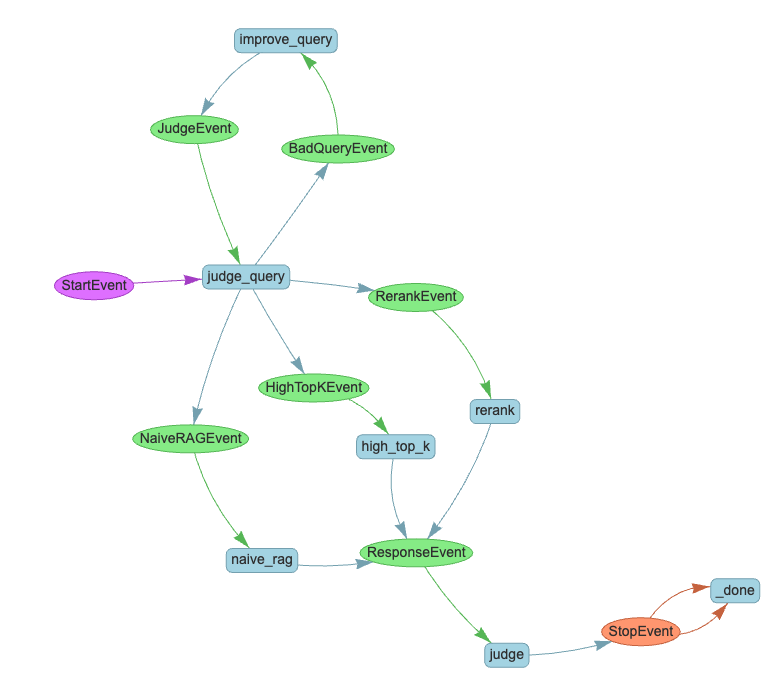

# Why workflows?


As generative AI applications become more complex, it becomes harder to manage the flow of data and control the execution of the application. Workflows provide a way to manage this complexity by breaking the application into smaller, more manageable pieces.

Other frameworks and LlamaIndex itself have attempted to solve this problem previously with directed acyclic graphs (DAGs) but these have a number of limitations that workflows do not:

- Logic like loops and branches needed to be encoded into the edges of graphs, which made them hard to read and understand.
- Passing data between nodes in a DAG created complexity around optional and default values and which parameters should be passed.
- DAGs did not feel natural to developers trying to developing complex, looping, branching AI applications.
The event-based pattern and vanilla python approach of Workflows resolves these problems.

For simple RAG pipelines and linear demos we do not expect you will need Workflows, but as your application grows in complexity, we hope you will reach for them.

# Basic Workflow

Workflows are built into LlamaIndex core, so to use them all you need is
`pip install llama-index-core`


During development you will probably find it helpful to visualize your workflow; you can use our built-in visualizer for this by installing it:
`pip install llama-index-utils-workflow`

In [1]:
from llama_index.core.workflow import (
    StartEvent,
    StopEvent,
    Workflow,
    step,
)

A Workflow orchestrates the execution of different components called "steps". 

Each step is responsible for handling certain event types and possibly emitting new events. Steps can be "bound" when they are defined as methods of the `Workflow` class itself, or "unbound" when they are defined as free functions. To define a step, the method or function must be decorated with the `@step` decorator.

Workflows provide basic validation to catch potential runtime errors as soon as possible. Validation happens once, when the workflow starts, and does not produce much overhead. It can be disabled in any case.

Use an instance of a `Workflow` class to run a workflow and stream events produced during execution. Workflows can be run step-by-step, by calling the `run_step` function multiple times until completion.

## Single-step workflow
A workflow is usually implemented as a class that inherits from `Workflow`. The class can define an arbitrary number of steps, each of which is a method decorated with `@step`. Here is the simplest possible workflow

In [2]:
class MyWorkflow(Workflow):
    @step
    async def my_step(self, ev:StartEvent) -> StopEvent:
        return StopEvent(result = 'Hello, world!')

w = MyWorkflow(timeout= 10, verbose= False)
result = await w.run()
print(result)
    

Hello, world!


In this code we:

- Define a class `MyWorkflow` that inherits from Workflow
- Use the @step decorator to define a single step `my_step`
- The step takes a single argument, `ev`, which is an instance of `StartEvent`
- The step returns a `StopEvent` with a result of "Hello, world!"
- We create an instance of `MyWorkflow` with a timeout of 10 seconds and verbosity off
- We run the workflow and print the result

---

### 📚 Further Reading

- **Events: `StartEvent` and `StopEvent`**  
  Understand how `StartEvent` and `StopEvent` function within LlamaIndex workflows:
  - [StartEvent Documentation](https://docs.llamaindex.ai/en/stable/api_reference/workflow/events/#llama_index.core.workflow.events.StartEvent)
  - [StopEvent Documentation](https://docs.llamaindex.ai/en/stable/api_reference/workflow/events/#llama_index.core.workflow.events.StopEvent)

- **Workflows**  
  Learn about the structure and execution of workflows in LlamaIndex:
  - [Workflows Guide](https://docs.llamaindex.ai/en/stable/module_guides/workflow/)
  - [Basic Workflow Example](https://docs.llamaindex.ai/en/stable/understanding/workflows/basic_flow/)

- **Workflow Parameters**  
  Explore the parameters and configurations applicable to workflows and events:
  - [Workflow Parameters Guide](https://docs.llamaindex.ai/en/stable/api_reference/workflow/workflow/)

---


# Type annotations for steps

The type annotations (e.g. `ev: StartEvent`) and -> `StopEvent` are essential to the way Workflows work. The expected types determine what event types will trigger a step. Tools like the visualizer (see below) also rely on these annotations to determine what types are generated and therefore where control flow goes next.

Type annotations are validated at compile time, so you will get an error message if for instance you emit an event that is never consumed by another step.

# Start and Stop events

`StartEvent` and `StopEvent` are special events that are used to start and stop a workflow. Any step that accepts a `StartEvent` will be triggered by the `run` command. Emitting a `StopEvent` will end the execution of the workflow and return a final result, even if other steps remain un-executed.

# Running a workflow in regular python

Workflows are async by default, so you use `await` to get the result of the `run` command. This will work fine in a notebook environment; in a vanilla python script you will need to import `asyncio` and wrap your code in an async function, like this:

```python
async def main():
    w = MyWorkflow(timeout=10, verbose=False)
    result = await w.run()
    print(result)

if __name__ == "__main__":
    import asyncio

    asyncio.run(main())

##  Understanding `async` and `await` in Workflows

---

```markdown
## 🌀 Understanding `async` and `await` in Python

In Python, **`async`** and **`await`** are used to handle tasks that take time (like downloading a file, waiting for a database, calling APIs) **without freezing** the entire program.

Instead of blocking everything while waiting, the program can **pause** and **do something else** in the meantime.

---

### What does `async` do?

- `async def` defines a **special function** called a **coroutine**.
- A coroutine can **pause itself** while waiting for something (like waiting for data).
- Think of it as a "promise" that the function will eventually produce a result.

Example:
```python
async def fetch_data():
    return 42
```
This function doesn't run immediately. It returns a **coroutine object** when you call it.

---

### What does `await` do?

- `await` is used **inside an `async` function** to **wait for the result** of another coroutine.
- It tells Python:  
  ➔ "Pause here until this task finishes, then continue."

Example:
```python
async def main():
    result = await fetch_data()
    print(result)
```
Here, `await fetch_data()` pauses until `fetch_data()` gives back `42`, then prints it.

---

### What happens if you **don't use `await`**?

If you forget to `await`, the coroutine **does not run immediately**.

Instead, you just get a **coroutine object** like this:

```python
>>> fetch_data()
<coroutine object fetch_data at 0x7f8c1ab3c840>
```

- No actual result is returned (like 42).
- Python simply **creates the coroutine** but **does not execute it**.
- It’s like ordering food but never picking it up — it's just waiting!

✅ Always `await` coroutines if you want the result.

---

### 🏡 Real-World Analogy

Imagine you order coffee at a busy café:
- **Normal code** (without async):  
  ➔ You order coffee and **stand in line doing nothing** until it’s ready.
- **Async/await code**:  
  ➔ You order coffee, then **go sit down and read a book**.  
  When your coffee is ready, the barista **calls you**, and you continue.

In Python:
- `async def` = "I’m ordering, but I won't block here."
- `await` = "Now I'm waiting for my coffee to be ready."

---

### 📌 Quick Summary

| Term | Meaning |
|:---|:---|
| `async def` | Creates a coroutine (something that can pause and resume) |
| `await` | Waits for a coroutine to finish and gives its result |
| Without `await` | Only creates the coroutine object (does not run it) |
| `asyncio.run()` | Runs an async function from regular Python scripts |

---
```

# Visualizing a workflow

Let's visualize the simple workflow we just created. This will create a file called `basic_workflow.html` in the current directory. Open it in your browser to see an interactive, visual representation of the workflow. It will look something like this:

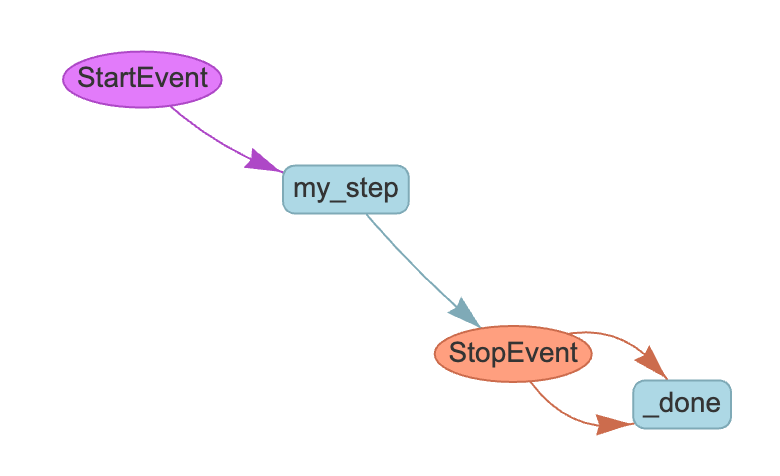

In [10]:
from llama_index.utils.workflow import draw_all_possible_flows

draw_all_possible_flows(MyWorkflow, filename="basic_workflow.html")


basic_workflow.html


gio: file:///home/tshepiso/workspace/coldblooded-agents/LlamaIndex-Tutorials/worflows/basic_workflow.html: Failed to find default application for content type ‘text/html’


In [21]:
from IPython.display import HTML, display
display(HTML(open('basic_workflow.html', encoding='utf-8').read()))


# Multi-step workflows

Multiple steps are created by defining custom events that can be emitted by steps and trigger other steps. Let's define a simple 3-step workflow.

We bring in our imports as before, plus a new import for Event.

In [12]:
from llama_index.core.workflow import (
    StartEvent,
    StopEvent,
    Workflow,
    step,
    Event,
)
from llama_index.utils.workflow import draw_all_possible_flows

In [13]:
class FirstEvent(Event):
    first_output: str

class SecondEvent(Event):
    second_output: str
   

## Defining the workflow

Now we define the workflow itself. We do this by defining the input and output types on each step.

- `step_one` takes a `StartEvent` and returns a `FirstEvent`
- `step_two` takes a `FirstEvent` and returns a `SecondEvent`
- `step_three` takes a `SecondEvent` and returns a `StopEvent`

In [17]:
class MyWorkflow(Workflow):
    @step
    async def step_one(self, ev:StartEvent) -> FirstEvent:
        print(ev.first_input)
        return FirstEvent(first_output = 'First step complete.')

    @step
    async def step_two(self, ev:FirstEvent) -> SecondEvent:
        print(ev.first_output)
        return SecondEvent(second_output = 'Second step complete.')     

    @step
    async def step_three(self, ev:SecondEvent) -> StopEvent:
        print(ev.second_output)
        return StopEvent(result = 'Workflow complete.')     

w = MyWorkflow(timeout= 10,verbose= False)
result = await w.run(first_input = 'Start the workflow') 
print(result)

Start the workflow
First step complete.
Second step complete.
Workflow complete.


In [18]:
from llama_index.utils.workflow import draw_all_possible_flows

draw_all_possible_flows(MyWorkflow, filename="multi_step_workflow.html")

multi_step_workflow.html


gio: file:///home/tshepiso/workspace/coldblooded-agents/LlamaIndex-Tutorials/worflows/multi_step_workflow.html: Failed to find default application for content type ‘text/html’


In [20]:
from IPython.display import HTML, display
display(HTML(open('multi_step_workflow.html', encoding='utf-8').read()))



## 🛠️ Multi-Step Workflow Explained

The diagram shows the **flow of a multi-step asynchronous workflow** in LlamaIndex.

Here’s what is happening step-by-step:

---

1. **StartEvent → step_one**
   - The workflow **begins** with a `StartEvent`.
   - `step_one` listens for `StartEvent` and starts the first operation.

2. **step_one → FirstEvent**
   - After `step_one` finishes, it emits a `FirstEvent`.
   - `FirstEvent` contains the result of the first operation.

3. **FirstEvent → step_two**
   - `step_two` listens for `FirstEvent`.
   - It processes the data from `FirstEvent`.

4. **step_two → SecondEvent**
   - After `step_two` finishes, it emits a `SecondEvent`.
   - `SecondEvent` contains the result of the second operation.

5. **SecondEvent → step_three**
   - `step_three` listens for `SecondEvent`.
   - It processes the data from `SecondEvent`.

6. **step_three → StopEvent**
   - After `step_three` finishes, it emits a `StopEvent`.
   - `StopEvent` signals that the workflow should **terminate**.

7. **StopEvent → _done**
   - Finally, the workflow reaches the special internal `_done` state, meaning **everything is completed**.

---

### 📈 Summary of Nodes and Connections

| Source | Action | Target |
|:---|:---|:---|
| `StartEvent` | triggers | `step_one` |
| `step_one` | emits | `FirstEvent` |
| `FirstEvent` | triggers | `step_two` |
| `step_two` | emits | `SecondEvent` |
| `SecondEvent` | triggers | `step_three` |
| `step_three` | emits | `StopEvent` |
| `StopEvent` | leads to | `_done` |

---

### 🎯 Key Takeaways
- **Events** (StartEvent, FirstEvent, SecondEvent, StopEvent) are used to **pass information** between steps.
- **Steps** (step_one, step_two, step_three) are the **work units** that do the processing.
- **StopEvent** cleanly ends the workflow.
- This structure is **fully asynchronous** — each step can wait without blocking the entire system.

✅ This design makes it easy to **build complex, modular workflows** where each part depends on the output of the previous one.
